In [1]:
# MTREND

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import plotly.graph_objects as go
import polars as pl
from dash import Dash, dcc, html
from plotly.subplots import make_subplots

nse = mcal.get_calendar("NSE")

In [2]:
pd.set_option("display.max_rows", 25_000)
pd.set_option("display.max_columns", 500)
pl.Config.set_tbl_cols(500)
pl.Config.set_tbl_rows(10_000)

pd.options.display.float_format = "{:.4f}".format

In [3]:
import sys

sys.path.append("..")
from tooling.enums import AssetClass, Index, Spot, StrikeSpread
from tooling.fetch import fetch_option_data, fetch_spot_data
from tooling.filter import find_atm, option_tool

In [4]:
def get_expiry(f_today):
    days_to_thursday = (3 - f_today.weekday()) % 7
    nearest_thursday = f_today + dt.timedelta(days=days_to_thursday)
    f_expiry = nearest_thursday
    if nse.valid_days(start_date=nearest_thursday, end_date=nearest_thursday).empty:
        f_expiry = nearest_thursday - dt.timedelta(days=1)
    return f_expiry


def get_option_contract_name(symbol, strike, expiry, opt_type):
    temp = "0"
    mth = expiry.month

    if (expiry + dt.timedelta(days=7)).month != expiry.month:
        date_string = expiry.strftime("%y%b").upper()
        return f"{symbol}{date_string}{strike}{opt_type}"
    else:
        if expiry.day <= 9:
            date_string = f"{expiry.year - 2000}{mth}{temp}{expiry.day}"
        else:
            date_string = f"{expiry.year - 2000}{mth}{expiry.day}"
        return f"{symbol}{date_string}{strike}{opt_type}"

In [5]:
bnf_pandas = pd.read_csv("../data/midcp_min (1).csv")

INDEX = 'MIDCP'
# INDEX = 'BNF'
# INDEX = 'NIFTY'
# INDEX = 'FNF'
# INDEX = 'STOCK'
# INDEX = 'SENSEX'

# lev_ = 1
INDEX_ = INDEX

if INDEX == 'BNF':
    lev_ = 6
    # lev_ = 4
    slippage_ = 0.0001
    lot_size_ = 30
    sma_ = 48
    tma_ = 18
    candles_ = 1
elif INDEX == 'NIFTY':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0002
    lot_size_ = 75
    sma_ = 32
    tma_ = 40
    candles_ = 1
elif INDEX == 'MIDCP':
    lev_ = 4.5
    # lev_ = 5
    slippage_ = 0.0005
    lot_size_ = 120
    sma_ = 9
    tma_ = 68
    candles_ = 1
elif INDEX == 'SENSEX':
    lev_ = 7.5
    # lev_ = 5
    slippage_ = 0.0001
    lot_size_ = 20
    sma_ = 45
    tma_ = 16
    candles_ = 1
elif INDEX == 'STOCK':
    lev_ = 5
    slippage_ = 0.001
    lot_size_ = 1
# bnf_pandas = pd.read_csv("../data/finnifty_1hr_tv (2).csv")
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv (4).csv')
# bnf_pandas = pd.read_csv('../data/finnifty_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/bnf_fut_1hr_tv.csv')
# bnf_pandas = pd.read_csv('../data/gold_4hr_tv.csv')


In [6]:
bnf_pandas['datetime'] = pd.to_datetime(bnf_pandas['datetime'])
bnf_pandas = bnf_pandas[bnf_pandas['datetime'].dt.time <= dt.time(15, 29)]
bnf_pandas.tail()

,index,datetime,open,high,low,close,volume
309946,midcpnifty,2025-05-30 15:25:00,12703.4000,12709.9500,12703.4000,12709.7500,0
309947,midcpnifty,2025-05-30 15:26:00,12709.1500,12710.6000,12704.4000,12705.5000,0
309948,midcpnifty,2025-05-30 15:27:00,12706.0000,12709.3500,12700.4500,12703.2500,0
309949,midcpnifty,2025-05-30 15:28:00,12705.2000,12706.7500,12695.4000,12700.0000,0
309950,midcpnifty,2025-05-30 15:29:00,12701.0500,12703.8000,12692.9000,12694.5000,0


In [7]:
def parse_timeframe(timeframe: str) -> pl.duration:
    if timeframe.endswith('m'):
        return pl.duration(minutes=int(timeframe[:-1]))
    elif timeframe.endswith('h'):
        return pl.duration(hours=int(timeframe[:-1]))
    # Add more cases if needed
    else:
        raise ValueError(f"Unknown timeframe format: {timeframe}")

def resample(data: pl.DataFrame, timeframe: str, offset: str = '0m') -> pl.DataFrame:
    # data = data.with_columns(
    #     pl.col("datetime").str.strptime(pl.Datetime, strict=False)   # <-- fix here
    # )
    return (
        data.set_sorted("datetime")
        .group_by_dynamic(
            index_column="datetime",
            every=timeframe,
            period=timeframe,
            label="left",
            offset=offset,
        )
        .agg(
            [
                pl.col("open").first().alias("open"),
                pl.col("high").max().alias("high"),
                pl.col("low").min().alias("low"),
                pl.col("close").last().alias("close"),
                pl.col("volume").sum().alias("volume"),
            ]
        )
    )


In [8]:
bnf = pl.DataFrame(bnf_pandas)
bnf_1hr = resample(bnf, '60m', '15m')   # offset can be '0m' if you want no offset
bnf = bnf_1hr

In [9]:
bnf.tail(100)

datetime,open,high,low,close,volume
datetime[ns],f64,f64,f64,f64,i64
2025-05-12 14:15:00,12518.95,12548.55,12503.35,12540.0,0
2025-05-12 15:15:00,12539.05,12545.85,12523.3,12529.65,0
2025-05-13 09:15:00,12571.55,12616.7,12513.65,12600.25,0
2025-05-13 10:15:00,12599.55,12630.85,12570.3,12622.35,0
2025-05-13 11:15:00,12624.25,12657.8,12622.7,12651.6,0
2025-05-13 12:15:00,12651.3,12662.35,12585.7,12605.95,0
2025-05-13 13:15:00,12605.95,12610.75,12552.3,12572.2,0
2025-05-13 14:15:00,12571.0,12591.5,12544.55,12574.6,0
2025-05-13 15:15:00,12574.6,12587.0,12563.5,12580.15,0


In [10]:
def generate_signals1(df, signal_ma, trailing_ma, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=signal_ma).mean()
    df["MA10"] = df["c"].rolling(window=trailing_ma).mean()

    df["Buy_Signal"] = 0

    # Generate signals using boolean masking
    buy_signal_mask = df["MA20"] > df["MA20"].shift(1)
    
    for i in range(1, candles_in_num):
        buy_signal_mask &= df["MA20"].shift(i) > df["MA20"].shift(i + 1)

    df.loc[buy_signal_mask, "Buy_Signal"] = 1

    return df

In [11]:
def generate_signals2(df, i, j, candles_in_num):
    df["c"] = pd.to_numeric(df["c"], errors="coerce")
    df["MA20"] = df["c"].rolling(window=i).mean()
    df["MA10"] = df["c"].rolling(window=j).mean()

    df["Sell_Signal"] = 0

    # Generate signals using boolean masking
    sell_signal_mask = df["MA20"] < df["MA20"].shift(1)

    for i in range(1, candles_in_num):
        sell_signal_mask &= df["MA20"].shift(i) < df["MA20"].shift(i + 1)

    df.loc[sell_signal_mask, "Sell_Signal"] = 1

    return df

In [12]:
# # Positional

# def execute(df):

#     trade_book = []
#     in_trade = False
#     signal_entry_price = 100000
#     signal_initial_sl = 0
#     already_signal_exists = False
#     is_trailing_active = False
#     remark = ""
#     portfolio_value = 6250000
#     previous_trade_exit_time = None

#     for i in range(1, len(df)):
#         points = 0
#         current_candle_open = df.iloc[i]["o"]
#         current_candle_high = df.iloc[i]["h"]
#         current_candle_low = df.iloc[i]["l"]
#         current_candle_close = df.iloc[i]["c"]
#         current_candle_datetime = df.iloc[i]['datetime']
#         current_moving_average_price = df.iloc[i]["MA10"]

#         if not in_trade:
#             if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
#                 if not already_signal_exists:
#                     # Fresh Buy Signal
#                     # print(df.iloc[i])
#                     # print('Fresh Buy Signal')
#                     signal_entry_price = current_candle_high
#                     signal_initial_sl = current_candle_low
#                     signal_creation_time = df.iloc[i]["datetime"]
#                     already_signal_exists = True

#                     # if (signal_entry_price - signal_initial_sl > 400):
#                     #     # Skip Signal Candle Due To Big Size
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                 else:
#                     # if current_candle_open > signal_entry_price:
#                     #     # Gap Up Open, SKIP trade
#                     #     # print(df.iloc[i])
#                     #     # print('Gap Up Open, Skip Trade')
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0
                    
#                     if current_candle_high < signal_entry_price:
#                         # Better Candle
#                         # print(df.iloc[i])
#                         # print('Better Candle')
#                         signal_entry_price = current_candle_high
#                         signal_initial_sl = current_candle_low
#                         signal_creation_time = df.iloc[i]["datetime"]

#                         # if (signal_entry_price - signal_initial_sl > 400):
#                         #     # Skip Signal Candle Due To Big Size
#                         #     already_signal_exists = False
#                         #     signal_entry_price = 100000
#                         #     signal_initial_sl = 0

#                     elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         # Entry Triggered
#                         # print(df.iloc[i])
#                         # print('Entry Triggered')
#                         in_trade = True
#                         entry_time = df.iloc[i]["datetime"]
#                         entry_price = signal_entry_price
#                         points = 0
#             else:
#                 if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
#                     # Considering the forward bias condition as well now
#                     signal_entry_price = df.iloc[i - 1]["h"]
#                     signal_initial_sl = df.iloc[i - 1]["l"]
#                     signal_creation_time = df.iloc[i - 1]["datetime"]
#                     already_signal_exists = True

#                     # if current_candle_open > signal_entry_price:
#                     #     already_signal_exists = False
#                     #     signal_entry_price = 100000
#                     #     signal_initial_sl = 0

#                     if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
#                         if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
#                             in_trade = True
#                             entry_time = df.iloc[i]["datetime"]
#                             entry_price = signal_entry_price
#                             points = 0
#                     else:
#                         # Discard Existing Signal
#                         already_signal_exists = False
#                         signal_entry_price = 100000
#                         signal_initial_sl = 0

#             # if df.iloc[i-1]["Buy_Signal"] == 1:
#             #     signal_entry_price = df.iloc[i-1]['h']
#             #     signal_initial_sl = df.iloc[i-1]['l']
#             #     signal_creation_time = df.iloc[i-1]["datetime"]

#             #     if current_candle_open > signal_entry_price:
#             #         # Gap Up Open, SKIP trade
#             #         already_signal_exists = False
#             #         signal_entry_price = 100000
#             #         signal_initial_sl = 0
                
#             #     elif current_candle_high >= signal_entry_price:
#             #         # Entry Triggered
#             #         in_trade = True
#             #         entry_time = df.iloc[i]["datetime"]
#             #         entry_price = signal_entry_price
#             #         points = 0

#         if in_trade:
#             trade_entry_price = signal_entry_price
#             trade_initial_sl = signal_initial_sl
#             trade_final_sl = signal_initial_sl

#             if (
#                 not is_trailing_active
#                 and current_candle_low > current_moving_average_price
#             ):
#                 is_trailing_active = True

#             if not is_trailing_active:
#                 if current_candle_open < trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit Before Gap Down'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # Initial SL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL Hit"

#             else:
#                 trade_final_sl = max(trade_initial_sl, current_moving_average_price)

#                 if current_candle_open <= trade_initial_sl:
#                     # if df.iloc[i-1]['l'] < trade_initial_sl:
#                     #     #Previous Candle Already Hit the SL Hence don't check gap down
#                     #     print(df.iloc[i])
#                     #     print('Initial SL Hit Before Gap Down')
#                     #     in_trade = False
#                     #     points = trade_initial_sl - trade_entry_price
#                     #     exit_price = trade_initial_sl
#                     #     exit_time = df.iloc[i-1]['datetime']
#                     #     remark = 'Initial SL Hit'
#                     # else:
#                     if (
#                         df.iloc[i]["datetime"].date() == entry_time.date()
#                         and df.iloc[i]["datetime"].time() == entry_time.time()
#                     ):
#                         if current_candle_close <= trade_initial_sl:
#                             in_trade = False
#                             points = trade_initial_sl - trade_entry_price
#                             exit_price = trade_initial_sl
#                             exit_time = df.iloc[i]["datetime"]
#                             remark = "Initial SL hit"

#                     else:
#                         # Gap Open Outside ISL
#                         # print(df.iloc[i])
#                         # print('Gap Open Outside ISL')
#                         in_trade = False
#                         points = current_candle_open - trade_entry_price
#                         exit_price = current_candle_open
#                         exit_time = df.iloc[i]["datetime"]
#                         remark = "Gap Open Outside ISL"

#                 elif current_candle_low <= trade_initial_sl:
#                     # if trade_initial_sl >= current_moving_average_price:
#                     # Despite Trailing, Initial SL hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = trade_initial_sl - trade_entry_price
#                     exit_price = trade_initial_sl
#                     exit_time = df.iloc[i]["datetime"]
#                     remark = "Initial SL hit"

#                 elif current_candle_close <= trade_final_sl:
#                     # Price Closed below TSL i.e. MA10 , TSL Hit
#                     # print(df.iloc[i])
#                     # print('Initial SL Hit')
#                     in_trade = False
#                     points = current_candle_close - trade_entry_price
#                     exit_price = current_candle_close
#                     exit_time = df.iloc[i]["datetime"]
#                     is_trailing_active = False
#                     remark = "TSL Hit"

#             if points:
#                 index_lev = lev_
#                 qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
#                 slippage = slippage_ * (entry_price + exit_price)
#                 # slippage = 10
#                 final_points = points - slippage
#                 # final_points = points
#                 previous_trade_exit_time = exit_time
#                 trade = {
#                     "Signal Generated At": signal_creation_time,
#                     "Trade Type": "LONG",
#                     "Entry Time": entry_time,
#                     "Entry Price": entry_price,
#                     "Initial SL": trade_initial_sl,
#                     "Final SL": trade_final_sl,
#                     "Exit Time": exit_time,
#                     "Exit Price": exit_price,
#                     "Points Captured": points,
#                     "After Costs": final_points,
#                     "PnL": final_points * qty,
#                     "Remarks": remark,
#                     "Qty": qty,
#                     "Leverage": index_lev,
#                     "ROI%": (final_points * qty / portfolio_value) * 100,
#                     "Trade Year": entry_time.year,
#                     "Trade Month": entry_time.month,
#                 }
#                 trade_book.append(trade)
#                 points = 0
#                 in_trade = False
#                 already_signal_exists = False
#                 remark = ""
#                 is_trailing_active = False

#     trade_book_df = pd.DataFrame(trade_book)
#     return trade_book_df

In [32]:
# Positional

def execute(df):

    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    is_trailing_active = False
    remark = ""
    portfolio_value = 3750000
    previous_trade_exit_time = None

    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_candle_datetime = df.iloc[i]['datetime']
        current_moving_average_price = df.iloc[i]["MA10"]

        if current_candle_datetime.time() == dt.time(15, 15):
            df.iloc[i]['Buy_Signal'] = 0
            # continue
        if not in_trade:
            if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                if df.iloc[i-1]['Buy_Signal'] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
                    signal_entry_price = df.iloc[i-1]['h']
                    signal_initial_sl = df.iloc[i-1]['l']
                    signal_creation_time = df.iloc[i-1]['datetime']
                    if current_candle_high >= signal_entry_price:
                        #Entry Triggered
                        entry_price = signal_entry_price
                        entry_time = current_candle_datetime
                        in_trade = True

        # if not in_trade:
        #     if current_candle_datetime.time() == dt.time(15, 15):
        #         df.iloc[i]["Buy_Signal"] = 0
        #         continue
        #     if df.iloc[i]["Buy_Signal"] == 1 and current_candle_datetime.time() < dt.time(15, 15):
        #         if not already_signal_exists:
        #             # Fresh Buy Signal
        #             # print(df.iloc[i])
        #             # print('Fresh Buy Signal')
        #             signal_entry_price = current_candle_high
        #             signal_initial_sl = current_candle_low
        #             signal_creation_time = df.iloc[i]["datetime"]
        #             already_signal_exists = True

        #             # if (signal_entry_price - signal_initial_sl > 400):
        #             #     # Skip Signal Candle Due To Big Size
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #         else:
        #             # if current_candle_open > signal_entry_price:
        #             #     # Gap Up Open, SKIP trade
        #             #     # print(df.iloc[i])
        #             #     # print('Gap Up Open, Skip Trade')
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0
                    
        #             if current_candle_high < signal_entry_price:
        #                 # Better Candle
        #                 # print(df.iloc[i])
        #                 # print('Better Candle')
        #                 signal_entry_price = current_candle_high
        #                 signal_initial_sl = current_candle_low
        #                 signal_creation_time = df.iloc[i]["datetime"]

        #                 # if (signal_entry_price - signal_initial_sl > 400):
        #                 #     # Skip Signal Candle Due To Big Size
        #                 #     already_signal_exists = False
        #                 #     signal_entry_price = 100000
        #                 #     signal_initial_sl = 0

        #             elif current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 # Entry Triggered
        #                 # print(df.iloc[i])
        #                 # print('Entry Triggered')
        #                 in_trade = True
        #                 entry_time = df.iloc[i]["datetime"]
        #                 entry_price = signal_entry_price
        #                 points = 0
        #     else:
        #         if df.iloc[i - 1]["Buy_Signal"] == 1 and df.iloc[i-1]['datetime'].time() < dt.time(15, 15):
        #             # Considering the forward bias condition as well now
        #             signal_entry_price = df.iloc[i - 1]["h"]
        #             signal_initial_sl = df.iloc[i - 1]["l"]
        #             signal_creation_time = df.iloc[i - 1]["datetime"]
        #             already_signal_exists = True

        #             # if current_candle_open > signal_entry_price:
        #             #     already_signal_exists = False
        #             #     signal_entry_price = 100000
        #             #     signal_initial_sl = 0

        #             if current_candle_high > signal_entry_price and current_candle_datetime.time() >= dt.time(10, 15):
        #                 if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
        #                     in_trade = True
        #                     entry_time = df.iloc[i]["datetime"]
        #                     entry_price = signal_entry_price
        #                     points = 0
        #             else:
        #                 # Discard Existing Signal
        #                 already_signal_exists = False
        #                 signal_entry_price = 100000
        #                signal_initial_sl = 0

            # if df.iloc[i-1]["Buy_Signal"] == 1:
            #     signal_entry_price = df.iloc[i-1]['h']
            #     signal_initial_sl = df.iloc[i-1]['l']
            #     signal_creation_time = df.iloc[i-1]["datetime"]

            #     if current_candle_open > signal_entry_price:
            #         # Gap Up Open, SKIP trade
            #         already_signal_exists = False
            #         signal_entry_price = 100000
            #         signal_initial_sl = 0
                
            #     elif current_candle_high >= signal_entry_price:
            #         # Entry Triggered
            #         in_trade = True
            #         entry_time = df.iloc[i]["datetime"]
            #         entry_price = signal_entry_price
            #         points = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_low > current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open < trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit Before Gap Down'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # Initial SL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

            else:
                trade_final_sl = max(trade_initial_sl, current_moving_average_price)

                if current_candle_open <= trade_initial_sl:
                    # if df.iloc[i-1]['l'] < trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     print(df.iloc[i])
                    #     print('Initial SL Hit Before Gap Down')
                    #     in_trade = False
                    #     points = trade_initial_sl - trade_entry_price
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close <= trade_initial_sl:
                            in_trade = False
                            points = trade_initial_sl - trade_entry_price
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL hit"

                    else:
                        # Gap Open Outside ISL
                        # print(df.iloc[i])
                        # print('Gap Open Outside ISL')
                        in_trade = False
                        points = current_candle_open - trade_entry_price
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_low <= trade_initial_sl:
                    # if trade_initial_sl >= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = trade_initial_sl - trade_entry_price
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close <= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = current_candle_close - trade_entry_price
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                index_lev = lev_
                qty = int(round(portfolio_value * index_lev / entry_price / lot_size_)) * lot_size_
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "LONG",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": index_lev,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False
                i += 1

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [33]:
bnf1 = bnf
bnf2 = bnf

In [34]:
def generate_stats(tb_expiry, signal_ma, trailing_ma):
    stats_df8 = pd.DataFrame(
        index=range(2017, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2017, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = f'{signal_ma} , {trailing_ma}'
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [35]:
bnf1 = bnf1.to_pandas()
bnf2 = bnf2.to_pandas()

In [36]:
bnf1['datetime'] = pd.to_datetime(bnf1['datetime'])
bnf2['datetime'] = pd.to_datetime(bnf2['datetime'])

In [37]:
bnf1 = bnf1[bnf1['datetime'].dt.time >= dt.time(9, 14)]
bnf1 = bnf2[bnf2['datetime'].dt.time >= dt.time(9, 14)]

In [38]:
bnf1.tail(650)

,datetime,open,high,low,close,volume
5138,2025-01-14 10:15:00,11914.3500,12044.8500,11890.5000,12040.5500,0
5139,2025-01-14 11:15:00,12040.6000,12041.1000,11977.1500,11991.8000,0
5140,2025-01-14 12:15:00,11992.1000,11996.6000,11939.3000,11967.3000,0
5141,2025-01-14 13:15:00,11967.3000,12020.0000,11953.2500,12013.8000,0
5142,2025-01-14 14:15:00,12013.6000,12037.2500,11984.0500,12030.4000,0
5143,2025-01-14 15:15:00,12030.1500,12067.4000,12022.1500,12061.7000,0
5144,2025-01-15 09:15:00,12088.6500,12103.9000,12011.5500,12079.7500,0
5145,2025-01-15 10:15:00,12078.9500,12200.0500,12068.6000,12175.9000,0
5146,2025-01-15 11:15:00,12176.4500,12210.5000,12163.4500,12205.8500,0
5147,2025-01-15 12:15:00,12205.5500,12213.6500,12164.7500,12165.1500,0


In [39]:
# stats_dictionary = {}

# for i in range(6, 81):
#     for j in range(4, 101, 2):
#         print(f"Signal MA : {i} , Trailing MA : {j}")
#         signals_df1 = generate_signals1(bnf1, i, j)
#         signals_df1 = signals_df1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#         new_tb = execute(signals_df1)
#         new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
#         tradebook_buy_side = new_tb
#         stats = generate_stats(tradebook_buy_side, i, j)
#         for overall_roi_dd_ratio, stats_df in stats.items():
#             if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 10:
#                 print(stats_df.to_string())
#                 stats_dictionary[overall_roi_dd_ratio] = stats_df

In [40]:
# sorted_stats = {k: v for k, v in sorted(stats_dictionary.items(), key=lambda item: item[0], reverse=True)}
# sorted_stats

In [41]:
bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [42]:
sma = 10
tma = 15
candles = 1
variation = f'{INDEX}, {sma} , {tma} , {candles}'
signals_df1 = generate_signals1(bnf1, sma, tma, candles)

In [43]:
# signals_df2.tail(130)

In [44]:

new_tb = execute(signals_df1)
# new_tb["DD%"] = new_tb["ROI%"].cumsum() - new_tb["ROI%"].cumsum().cummax()
tradebook_buy_side = new_tb
# new_tb

/tmp/ipykernel_16006/3715834428.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[i]['Buy_Signal'] = 0


In [45]:
# tradebook_buy_side['DD%'] = (tradebook_buy_side['ROI%'].cumsum() - tradebook_buy_side['ROI%'].cumsum().cummax())
# tradebook_buy_side

In [46]:
new_tb.tail(500)

,Signal Generated At,Trade Type,Entry Time,Entry Price,Initial SL,Final SL,Exit Time,Exit Price,Points Captured,After Costs,PnL,Remarks,Qty,Leverage,ROI%,Trade Year,Trade Month
0,2022-01-25 14:15:00,LONG,2022-01-25 15:15:00,7365.2500,7325.9000,7325.9000,2022-01-27 09:15:00,7307.3000,-57.9500,-65.2863,-148852.7070,Gap Open Outside ISL,2280,4.5000,-3.9694,2022,1
1,2022-01-27 14:15:00,LONG,2022-01-27 15:15:00,7360.2000,7298.1000,7508.7800,2022-02-01 12:15:00,7475.8000,115.6000,108.1820,246654.9600,TSL Hit,2280,4.5000,6.5775,2022,1
2,2022-02-01 13:15:00,LONG,2022-02-01 14:15:00,7574.5000,7462.5500,7644.0567,2022-02-03 11:15:00,7639.5000,65.0000,57.3930,130856.0400,TSL Hit,2280,4.5000,3.4895,2022,2
3,2022-02-09 09:15:00,LONG,2022-02-09 10:15:00,7459.8500,7422.8000,7506.1867,2022-02-11 09:15:00,7439.5500,-20.3000,-27.7497,-63269.3160,TSL Hit,2280,4.5000,-1.6872,2022,2
4,2022-02-15 12:15:00,LONG,2022-02-15 13:15:00,7178.2500,7125.0500,7311.7067,2022-02-17 13:15:00,7288.2000,109.9500,102.7168,246520.2600,TSL Hit,2400,4.5000,6.5739,2022,2
5,2022-02-18 11:15:00,LONG,2022-02-18 12:15:00,7282.6000,7260.2500,7260.2500,2022-02-18 13:15:00,7260.2500,-22.3500,-29.6214,-67536.8490,Initial SL Hit,2280,4.5000,-1.8010,2022,2
6,2022-02-23 10:15:00,LONG,2022-02-23 11:15:00,7165.2000,7134.8500,7134.8500,2022-02-23 12:15:00,7134.8500,-30.3500,-37.5000,-90000.0600,Initial SL hit,2400,4.5000,-2.4000,2022,2
7,2022-02-25 13:15:00,LONG,2022-02-25 14:15:00,6938.8500,6896.6000,6896.6000,2022-02-28 09:15:00,6874.9000,-63.9500,-70.8569,-170056.5000,Gap Open Outside ISL,2400,4.5000,-4.5348,2022,2
8,2022-02-28 10:15:00,LONG,2022-02-28 11:15:00,6933.2000,6851.4000,6953.9267,2022-03-02 13:15:00,6949.3500,16.1500,9.2087,22100.9400,TSL Hit,2400,4.5000,0.5894,2022,2
9,2022-03-02 14:15:00,LONG,2022-03-02 15:15:00,6993.8500,6920.7000,6980.0633,2022-03-03 12:15:00,6949.7500,-44.1000,-51.0718,-122572.3200,TSL Hit,2400,4.5000,-3.2686,2022,3


In [47]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2019, 2026),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2019, 2026):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation

    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    
    # print(f'{overall_total_roi} , {overall_max_drawdown} , {overall_roi_dd_ratio}')
    
    return {overall_roi_dd_ratio: stats_df8}

In [48]:
final_stats = None
stats = generate_stats(tradebook_buy_side, variation)
for x, y in stats.items():
    final_stats = y

final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2019,0.0000,0,NaN,NaN,NaN,NaN,NaN,"MIDCP, 10 , 15 , 1"
2020,0.0000,0,NaN,NaN,NaN,NaN,NaN,"MIDCP, 10 , 15 , 1"
2021,0.0000,0,NaN,NaN,NaN,NaN,NaN,"MIDCP, 10 , 15 , 1"
2022,72.6717,79,31.6456,8.1210,-2.4140,-24.4367,2.9739,"MIDCP, 10 , 15 , 1"
2023,109.2001,69,47.8261,5.2668,-1.7945,-13.8660,7.8754,"MIDCP, 10 , 15 , 1"
2024,45.8693,83,34.9398,5.9367,-2.3388,-25.2535,1.8164,"MIDCP, 10 , 15 , 1"
2025,52.8302,26,30.7692,13.0486,-2.8644,-23.8004,2.2197,"MIDCP, 10 , 15 , 1"
Overall,280.5713,257,36.9650,6.8777,-2.3013,-32.4365,8.6499,"MIDCP, 10 , 15 , 1"


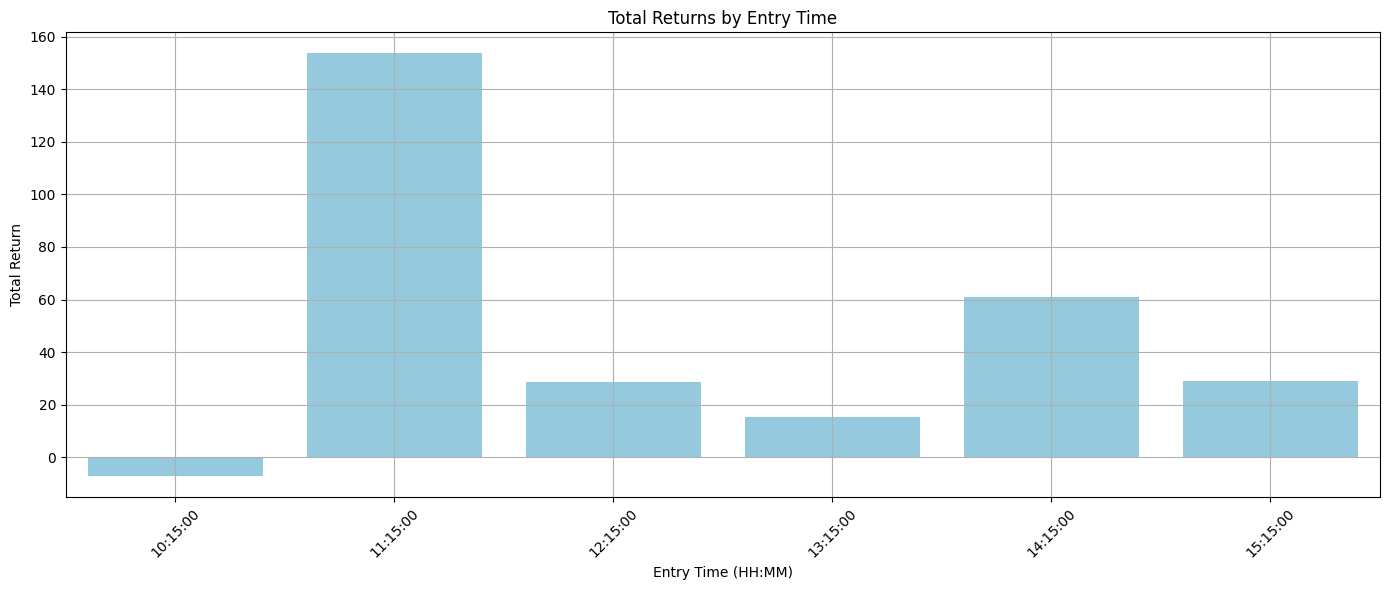

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = tradebook_buy_side.copy()  # your DataFrame

# Step 1: Convert time to string format (HH:MM) for better x-axis display
df['entry_time_str'] = df['Entry Time'].dt.time.apply(lambda t: t.strftime('%H:%M:%S'))

# Step 2: Group by time and sum the returns
agg_df = df.groupby('entry_time_str')['ROI%'].sum().reset_index()

# Step 3: Plot the summed returns by time
plt.figure(figsize=(14, 6))
sns.barplot(x='entry_time_str', y='ROI%', data=agg_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Total Returns by Entry Time')
plt.xlabel('Entry Time (HH:MM)')
plt.ylabel('Total Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
tradebook_buy_side.to_csv(f'{INDEX_}_mtrend.csv', index=False)

In [57]:
# bnf1 = bnf1.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})

In [31]:
stats_dict = {}

for i in range(6, 15):
    for j in range(12, 19):
            variation = f'SMA: {i}, TMA: {j}'
            print(variation)
            signals_df1 = generate_signals1(bnf1, i, j, 1)
            new_tb = execute(signals_df1)
            stats = generate_stats(new_tb, variation)
            for overall_roi_dd_ratio, stats_df in stats.items():
                if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 6:
                    stats_dict[overall_roi_dd_ratio] = stats_df
                    print(stats_df.to_string())

SMA: 6, TMA: 12
SMA: 6, TMA: 13
SMA: 6, TMA: 14
SMA: 6, TMA: 15
SMA: 6, TMA: 16
SMA: 6, TMA: 17
SMA: 6, TMA: 18
SMA: 7, TMA: 12
SMA: 7, TMA: 13
SMA: 7, TMA: 14
SMA: 7, TMA: 15
SMA: 7, TMA: 16
SMA: 7, TMA: 17
SMA: 7, TMA: 18
SMA: 8, TMA: 12
SMA: 8, TMA: 13
SMA: 8, TMA: 14
SMA: 8, TMA: 15
SMA: 8, TMA: 16
SMA: 8, TMA: 17
SMA: 8, TMA: 18
SMA: 9, TMA: 12
SMA: 9, TMA: 13
SMA: 9, TMA: 14
        Total ROI Total Trades Win Rate Avg Profit% per Trade Avg Loss% per Trade Max Drawdown ROI/DD Ratio        Variation
2019       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  SMA: 9, TMA: 14
2020       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  SMA: 9, TMA: 14
2021       0.0000            0      NaN                   NaN                 NaN          NaN          NaN  SMA: 9, TMA: 14
2022      83.9299           73  34.2466                8.0090             -2.4228     -22.1176       3.7947  SMA: 9,

In [32]:
sorted_stats = {k: v for k, v in sorted(stats_dict.items(), key=lambda item: item[0], reverse=True)}

In [33]:
sorted_stats

{7.714286037566757:         Total ROI Total Trades Win Rate Avg Profit% per Trade  \
 2019       0.0000            0      NaN                   NaN   
 2020       0.0000            0      NaN                   NaN   
 2021       0.0000            0      NaN                   NaN   
 2022      77.7835           77  32.4675                8.1049   
 2023     110.9895           69  47.8261                5.2677   
 2024      44.2505           84  33.3333                6.1851   
 2025      17.8189           14  35.7143                9.9045   
 Overall  250.8423          244  37.2951                6.5842   
 
         Avg Loss% per Trade Max Drawdown ROI/DD Ratio         Variation  
 2019                    NaN          NaN          NaN  SMA: 10, TMA: 15  
 2020                    NaN          NaN          NaN  SMA: 10, TMA: 15  
 2021                    NaN          NaN          NaN  SMA: 10, TMA: 15  
 2022                -2.4008     -22.5456       3.4501  SMA: 10, TMA: 15  
 2023     

# MTrend BNF

In [36]:
# new_tb.to_csv('BNF Mtrend New.csv', index=False)

In [139]:
# Positional Sell Side


def execute_sell_side(df):
    portfolio_value = 7500000
    trade_book = []
    in_trade = False
    signal_entry_price = 100000
    signal_initial_sl = 0
    already_signal_exists = False
    remark = ""
    is_trailing_active = False
    previous_trade_exit_time = None

    print(lev_, slippage_, portfolio_value)
    for i in range(1, len(df)):
        points = 0
        current_candle_open = df.iloc[i]["o"]
        current_candle_high = df.iloc[i]["h"]
        current_candle_low = df.iloc[i]["l"]
        current_candle_close = df.iloc[i]["c"]
        current_moving_average_price = df.iloc[i]["MA10"]

        if not in_trade:
            if df.iloc[i]["Sell_Signal"] == 1:
                if not already_signal_exists:
                    # Fresh Sell Signal
                    # print(df.iloc[i])
                    # print('Fresh Short Sell Signal')
                    signal_entry_price = current_candle_low
                    signal_initial_sl = current_candle_high
                    signal_creation_time = df.iloc[i]["datetime"]
                    already_signal_exists = True

                    # if (signal_initial_sl - signal_entry_price > 400):
                    #     # Skip Signal Candle Due To Big Size
                    #     already_signal_exists = False
                    #     signal_entry_price = 100000
                    #     signal_initial_sl = 0

                else:
                    if current_candle_open < signal_entry_price:
                        # Gap Down Outside, SKIP trade
                        # print('Signal Entry Price' , signal_entry_price)
                        # print(df.iloc[i])
                        # print('Gap Outside, Skip Trade')
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0
                    elif current_candle_low > signal_entry_price:
                        # Better Candle
                        
                        # print(df.iloc[i])
                        # print('Better Candle')
                        signal_entry_price = current_candle_low
                        signal_initial_sl = current_candle_high
                        signal_creation_time = df.iloc[i]["datetime"]

                        # if (signal_initial_sl - signal_entry_price > 400):
                        #     # Skip Signal Candle Due To Big Size
                        #     already_signal_exists = False
                        #     signal_entry_price = 100000
                        #     signal_initial_sl = 0

                    elif current_candle_low < signal_entry_price:
                        # Entry Triggered
                        
                        # print(df.iloc[i])
                        # print('Entry Triggered')
                        in_trade = True
                        entry_time = df.iloc[i]["datetime"]
                        entry_price = signal_entry_price
                        points = 0
            else:
                if df.iloc[i - 1]["Sell_Signal"] == 1:
                    # Considering the forward bias condition as well now
                    signal_entry_price = df.iloc[i - 1]["l"]
                    signal_initial_sl = df.iloc[i - 1]["h"]
                    signal_creation_time = df.iloc[i - 1]["datetime"]
                    already_signal_exists = True

                    if current_candle_low < signal_entry_price:
                        if df.iloc[i-1]['datetime'] != previous_trade_exit_time:
                            in_trade = True
                            entry_time = df.iloc[i]["datetime"]
                            entry_price = signal_entry_price
                            points = 0
                    else:
                        # Discard Existing Signal
                        already_signal_exists = False
                        signal_entry_price = 100000
                        signal_initial_sl = 0

        if in_trade:
            trade_entry_price = signal_entry_price
            trade_initial_sl = signal_initial_sl
            trade_final_sl = signal_initial_sl

            if (
                not is_trailing_active
                and current_candle_high < current_moving_average_price
            ):
                is_trailing_active = True

            if not is_trailing_active:
                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # Initial SL Hit
                    
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL Hit"

                elif current_candle_close >= trade_final_sl:
                    # TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    remark = "TSL Hit"

            elif is_trailing_active:
                trade_final_sl = min(trade_initial_sl, current_moving_average_price)

                if current_candle_open > trade_initial_sl:
                    # if df.iloc[i-1]['h'] > trade_initial_sl:
                    #     #Previous Candle Already Hit the SL Hence don't check gap down
                    #     in_trade = False
                    #     points = -1 * (trade_initial_sl - trade_entry_price)
                    #     exit_price = trade_initial_sl
                    #     exit_time = df.iloc[i-1]['datetime']
                    #     remark = 'Initial SL Hit'
                    # else:
                    if (
                        df.iloc[i]["datetime"].date() == entry_time.date()
                        and df.iloc[i]["datetime"].time() == entry_time.time()
                    ):
                        if current_candle_close >= trade_initial_sl:
                            in_trade = False
                            points = -1 * (trade_initial_sl - trade_entry_price)
                            exit_price = trade_initial_sl
                            exit_time = df.iloc[i]["datetime"]
                            remark = "Initial SL Hit"
                    else:
                        # Gap Open Outside ISL
                        
                        # print(df.iloc[i])
                        # print('Gap Outside Initial SL')
                        in_trade = False
                        points = trade_entry_price - current_candle_open
                        exit_price = current_candle_open
                        exit_time = df.iloc[i]["datetime"]
                        remark = "Gap Open Outside ISL"

                elif current_candle_high >= trade_initial_sl:
                    # if trade_initial_sl <= current_moving_average_price:
                    # Despite Trailing, Initial SL hit
                    # print(df.iloc[i])
                    # print('Initial SL Hit')
                    in_trade = False
                    points = -1 * (trade_initial_sl - trade_entry_price)
                    exit_price = trade_initial_sl
                    exit_time = df.iloc[i]["datetime"]
                    remark = "Initial SL hit"

                elif current_candle_close >= trade_final_sl:
                    # Price Closed below TSL i.e. MA10 , TSL Hit
                    # print(df.iloc[i])
                    # print('TSL Hit')
                    in_trade = False
                    points = -1 * (current_candle_close - trade_entry_price)
                    exit_price = current_candle_close
                    exit_time = df.iloc[i]["datetime"]
                    is_trailing_active = False
                    remark = "TSL Hit"

            if points:
                qty = int(round((portfolio_value * lev_ / entry_price) / lot_size_) * lot_size_)
                slippage = slippage_ * (entry_price + exit_price)
                # slippage = 10
                final_points = points - slippage
                # final_points = points
                previous_trade_exit_time = exit_time
                trade = {
                    "Signal Generated At": signal_creation_time,
                    "Trade Type": "SHORT",
                    "Entry Time": entry_time,
                    "Entry Price": entry_price,
                    "Initial SL": trade_initial_sl,
                    "Final SL": trade_final_sl,
                    "Exit Time": exit_time,
                    "Exit Price": exit_price,
                    "Points Captured": points,
                    "After Costs": final_points,
                    "PnL": final_points * qty,
                    "Remarks": remark,
                    "Qty": qty,
                    "Leverage": lev_,
                    "ROI%": (final_points * qty / portfolio_value) * 100,
                    "Trade Year": entry_time.year,
                    "Trade Month": entry_time.month,
                }
                # print(trade)
                trade_book.append(trade)
                points = 0
                in_trade = False
                already_signal_exists = False
                remark = ""
                is_trailing_active = False

    trade_book_df = pd.DataFrame(trade_book)
    return trade_book_df

In [38]:
# bnf_pandas = pd.read_csv('../data/midcp_1hr_tv_new.csv')

In [39]:
# bnf_pandas.head()

In [40]:
# # If Stocks Data ...
# bnf_pandas["datetime"] = pd.to_datetime(bnf_pandas["time"])
# bnf_pandas["datetime"] = bnf_pandas["datetime"].dt.tz_localize(None)
# bnf_pandas = bnf_pandas[bnf_pandas["datetime"].dt.year >= 2017]
# bnf_pandas.drop(columns=["time"], inplace=True)
# # bnf_pandas

In [41]:
# bnf = pl.DataFrame(bnf_pandas)
# bnf = bnf.with_columns([pl.col("datetime").alias("index")]).drop("datetime")


In [42]:
# data = pl.DataFrame(data)
# data = data.with_columns([
#     pl.col("datetime").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
# ])

In [140]:
def generate_stats(tb_expiry, variation):
    stats_df8 = pd.DataFrame(
        index=range(2022, 2025),
        columns=[
            "Total ROI",
            "Total Trades",
            "Win Rate",
            "Avg Profit% per Trade",
            "Avg Loss% per Trade",
            "Max Drawdown",
            "ROI/DD Ratio",
            "Variation",
        ],
    )
    combined_df_sorted = tb_expiry
    # combined_df_sorted = tb_expiry_ce
    # combined_df_sorted = tb_expiry_pe
    
    # Iterate over each year
    for year in range(2022, 2025):
        # Filter trades for the current year
        year_trades = combined_df_sorted[(combined_df_sorted["Trade Year"] == year)]
    
        # Calculate total ROI
        total_roi = year_trades["ROI%"].sum()
    
        # Calculate total number of trades
        total_trades = len(year_trades)
    
        # Calculate win rate
        win_rate = (year_trades["ROI%"] > 0).mean() * 100
    
        # Calculate average profit per trade
        avg_profit = year_trades[year_trades["ROI%"] > 0]["ROI%"].mean()
    
        # Calculate average loss per trade
        avg_loss = year_trades[year_trades["ROI%"] < 0]["ROI%"].mean()
    
        # Calculate maximum drawdown
        max_drawdown = (
            year_trades["ROI%"].cumsum() - year_trades["ROI%"].cumsum().cummax()
        ).min()
    
        # Calculate ROI/DD ratio
        roi_dd_ratio = total_roi / abs(max_drawdown)

        variation = variation
    
        # Store the statistics in the DataFrame
        stats_df8.loc[year] = [
            total_roi,
            total_trades,
            win_rate,
            avg_profit,
            avg_loss,
            max_drawdown,
            roi_dd_ratio,
            variation,
        ]
    
    # Calculate overall statistics
    overall_total_roi = stats_df8["Total ROI"].sum()
    overall_total_trades = stats_df8["Total Trades"].sum()
    overall_win_rate = (combined_df_sorted["ROI%"] > 0).mean() * 100
    overall_avg_profit = combined_df_sorted[combined_df_sorted["ROI%"] > 0]["ROI%"].mean()
    overall_avg_loss = combined_df_sorted[combined_df_sorted["ROI%"] < 0]["ROI%"].mean()
    overall_max_drawdown = (
        combined_df_sorted["ROI%"].cumsum() - combined_df_sorted["ROI%"].cumsum().cummax()
    ).min()
    overall_roi_dd_ratio = overall_total_roi / abs(overall_max_drawdown)
    overall_variation = variation
    
    # Store the overall statistics in the DataFrame
    stats_df8.loc["Overall"] = [
        overall_total_roi,
        overall_total_trades,
        overall_win_rate,
        overall_avg_profit,
        overall_avg_loss,
        overall_max_drawdown,
        overall_roi_dd_ratio,
        overall_variation,
    ]
    return {overall_roi_dd_ratio : stats_df8}

In [44]:
# targets = [2, 4, 6, 8, 10, 12, 15, 18, 20, 25, 30, 50, 100]
# time_frames = ["3m", "5m", "10m", "15m", "30m", "60m"]
# num_candles = [1, 2, 3, 4, 5]
# for i in range(5, 81, 5):
#     for j in range(5, 81, 5):
#         for k in targets:
#             for tf in time_frames:
#                 for candles in num_candles:
#                     if tf == "10m":
#                         offset = "5m"
#                     elif tf == "30m" or tf == "60m":
#                         offset = "15m"
#                     else:
#                         offset = "0m"
#                     variation = f"SMA: {i}, TMA: {j}, Target: {k}R, TF: {tf}, Candles: {candles}"
#                     print(variation)
#                     data_w_signals = (resample(data, tf, offset)).to_pandas()
#                     data_w_signals = generate_signals2(data_w_signals, i, j, candles)
#                     data_w_signals2 = data_w_signals.rename(columns={"open": "o", "high": "h", "low": "l", "close": "c"})
#                     sell_tb = execute_sell_side(data_w_signals2)
#                     stats = generate_stats(sell_tb, variation)
#                     for overall_roi_dd_ratio, stats_df in stats.items():
#                         if overall_roi_dd_ratio is not None and overall_roi_dd_ratio > 3:
#                             print(stats_df.to_string())
#                             stats_dictionary[overall_roi_dd_ratio] = stats_df

In [ ]:
# tradebook_sell_side

In [45]:
# bnf_pandas.head()

In [180]:
signals_df1 = generate_signals2(bnf1, 50, 49, 5)
tradebook_sell_side = execute_sell_side(signals_df1)

3 0.0005 7500000


In [182]:
# tradebook_sell_side = tradebook_sell_side[154:]
tradebook_sell_side

,Signal Generated At,Trade Type,Entry Time,Entry Price,Initial SL,Final SL,Exit Time,Exit Price,Points Captured,After Costs,PnL,Remarks,Qty,Leverage,ROI%,Trade Year,Trade Month
0,2022-01-21 10:15:00,SHORT,2022-01-21 11:15:00,7616.7500,7690.5500,7544.0520,2022-01-28 10:15:00,7549.4500,67.3000,59.7169,176164.8550,TSL Hit,2950,3,2.3489,2022,1
1,2022-01-28 11:15:00,SHORT,2022-01-28 12:15:00,7548.7000,7579.8000,7494.0082,2022-01-31 10:15:00,7508.9500,39.7500,32.2212,96663.5250,TSL Hit,3000,3,1.2888,2022,1
2,2022-01-31 13:15:00,SHORT,2022-01-31 14:15:00,7514.1500,7543.8000,7543.8000,2022-02-01 09:15:00,7587.2500,-73.1000,-80.6507,-241952.1000,Gap Open Outside ISL,3000,3,-3.2260,2022,1
3,2022-02-01 10:15:00,SHORT,2022-02-01 11:15:00,7560.3500,7589.5500,7589.5500,2022-02-01 14:15:00,7589.5500,-29.2000,-36.7749,-110324.8500,Initial SL Hit,3000,3,-1.4710,2022,2
4,2022-02-09 15:15:00,SHORT,2022-02-10 09:15:00,7505.7000,7516.8000,7516.8000,2022-02-10 10:15:00,7516.8000,-11.1000,-18.6113,-55833.7500,Initial SL Hit,3000,3,-0.7445,2022,2
5,2022-02-10 12:15:00,SHORT,2022-02-10 13:15:00,7548.0500,7570.2500,6993.5082,2022-03-03 09:15:00,7000.4500,547.6000,540.3258,1620977.2500,TSL Hit,3000,3,21.6130,2022,2
6,2022-03-03 11:15:00,SHORT,2022-03-03 12:15:00,6978.0500,7006.1000,6808.5071,2022-03-09 12:15:00,6826.9500,151.1000,144.1975,461432.0000,TSL Hit,3200,3,6.1524,2022,3
7,2022-03-11 12:15:00,SHORT,2022-03-11 13:15:00,6885.2000,6910.7500,6910.7500,2022-03-11 13:15:00,6910.7500,-25.5500,-32.4480,-105455.9188,Initial SL Hit,3250,3,-1.4061,2022,3
8,2022-03-11 15:15:00,SHORT,2022-03-14 09:15:00,6930.3500,6942.6000,6942.6000,2022-03-14 14:15:00,6942.6000,-12.2500,-19.1865,-62356.0438,Initial SL Hit,3250,3,-0.8314,2022,3
9,2022-04-19 11:15:00,SHORT,2022-04-19 12:15:00,7451.6500,7479.4500,7311.8724,2022-04-29 10:15:00,7325.8000,125.8500,118.4613,355383.8250,TSL Hit,3000,3,4.7385,2022,4


In [177]:
st = generate_stats(tradebook_sell_side, '///')

In [178]:
final_stats = pd.DataFrame()
for x, y in st.items():
    final_stats = pd.DataFrame(y)

In [166]:
final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2022,0.0000,0,NaN,NaN,NaN,NaN,NaN,///
2023,0.0000,0,NaN,NaN,NaN,NaN,NaN,///
2024,-33.9828,27,7.4074,1.3250,-1.4653,-33.1398,-1.0254,///
Overall,-33.9828,27,7.4074,1.3250,-1.4653,-33.1398,-1.0254,///


# Stats from May 2024 to Oct 2024

In [179]:
final_stats

,Total ROI,Total Trades,Win Rate,Avg Profit% per Trade,Avg Loss% per Trade,Max Drawdown,ROI/DD Ratio,Variation
2022,79.8412,30,36.6667,9.7085,-1.4186,-6.4194,12.4374,///
2023,6.4825,23,30.4348,3.6107,-1.1745,-6.7692,0.9576,///
2024,-15.5394,21,9.5238,4.7988,-1.3230,-14.0853,-1.1032,///
Overall,70.7843,74,27.0270,7.0833,-1.3126,-16.5891,4.2669,///


# Initial Stats till May 2024

In [176]:
tradebook_sell_side = tradebook_sell_side[:74]
# tradebook_sell_side

In [183]:
tradebook_sell_side

,Signal Generated At,Trade Type,Entry Time,Entry Price,Initial SL,Final SL,Exit Time,Exit Price,Points Captured,After Costs,PnL,Remarks,Qty,Leverage,ROI%,Trade Year,Trade Month
0,2022-01-21 10:15:00,SHORT,2022-01-21 11:15:00,7616.7500,7690.5500,7544.0520,2022-01-28 10:15:00,7549.4500,67.3000,59.7169,176164.8550,TSL Hit,2950,3,2.3489,2022,1
1,2022-01-28 11:15:00,SHORT,2022-01-28 12:15:00,7548.7000,7579.8000,7494.0082,2022-01-31 10:15:00,7508.9500,39.7500,32.2212,96663.5250,TSL Hit,3000,3,1.2888,2022,1
2,2022-01-31 13:15:00,SHORT,2022-01-31 14:15:00,7514.1500,7543.8000,7543.8000,2022-02-01 09:15:00,7587.2500,-73.1000,-80.6507,-241952.1000,Gap Open Outside ISL,3000,3,-3.2260,2022,1
3,2022-02-01 10:15:00,SHORT,2022-02-01 11:15:00,7560.3500,7589.5500,7589.5500,2022-02-01 14:15:00,7589.5500,-29.2000,-36.7749,-110324.8500,Initial SL Hit,3000,3,-1.4710,2022,2
4,2022-02-09 15:15:00,SHORT,2022-02-10 09:15:00,7505.7000,7516.8000,7516.8000,2022-02-10 10:15:00,7516.8000,-11.1000,-18.6113,-55833.7500,Initial SL Hit,3000,3,-0.7445,2022,2
5,2022-02-10 12:15:00,SHORT,2022-02-10 13:15:00,7548.0500,7570.2500,6993.5082,2022-03-03 09:15:00,7000.4500,547.6000,540.3258,1620977.2500,TSL Hit,3000,3,21.6130,2022,2
6,2022-03-03 11:15:00,SHORT,2022-03-03 12:15:00,6978.0500,7006.1000,6808.5071,2022-03-09 12:15:00,6826.9500,151.1000,144.1975,461432.0000,TSL Hit,3200,3,6.1524,2022,3
7,2022-03-11 12:15:00,SHORT,2022-03-11 13:15:00,6885.2000,6910.7500,6910.7500,2022-03-11 13:15:00,6910.7500,-25.5500,-32.4480,-105455.9188,Initial SL Hit,3250,3,-1.4061,2022,3
8,2022-03-11 15:15:00,SHORT,2022-03-14 09:15:00,6930.3500,6942.6000,6942.6000,2022-03-14 14:15:00,6942.6000,-12.2500,-19.1865,-62356.0438,Initial SL Hit,3250,3,-0.8314,2022,3
9,2022-04-19 11:15:00,SHORT,2022-04-19 12:15:00,7451.6500,7479.4500,7311.8724,2022-04-29 10:15:00,7325.8000,125.8500,118.4613,355383.8250,TSL Hit,3000,3,4.7385,2022,4


In [184]:
tradebook_sell_side.to_csv('All midcp short trades MTREND.csv')